# 3.4 LangGraph 내장 도구(tool)를 활용해서 만드는 Agent

- LangGraph는 많은 [내장 도구들](https://python.langchain.com/docs/integrations/tools/)을 제공합니다
- 이 강의에서는 내장 도구를 활용해서 에이전트를 만드는 방법을 알아봅니다
- 커스텀 도구를 만들기 전에 내장 도구를 먼저 확인하면 개발 효율을 높일 수 있습니다

In [19]:
from dotenv import load_dotenv

load_dotenv("../.env")

True

In [20]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.1")
# llm = ChatOllama(model="qwen2.5")

In [21]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a+b

@tool
def mul(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a*b

- 간단한 웹 검색 도구를 활용합니다 
- [Tavily](https://tavily.com/)는 매월 1000건의 무료 호출을 제공하지만 [DuckDuckGo](https://duckduckgo.com/)는 완전 무료입니다

In [22]:
# from langchain_tavily import TavilySearch

# search_tool = TavilySearch(
#     max_results=1,
#     topic="general",  # "news", "finance"
#     include_answer=True,
#     include_raw_content=True,
#     include_images=True,
#     include_image_descriptions=True,
#     search_depth="advanced",  # "basic"
# )

In [23]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()
search_tool

DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text'))

- [LangChain integrations packages](https://docs.langchain.com/oss/python/integrations/providers/overview)
- [Gmail Toolkit](https://docs.langchain.com/oss/python/integrations/tools/google_gmail)은 구글 메일 도구를 제공합니다
    - 먼저 `credentials` 설정 후에 사용할 수 있습니다
    - [Create access credentials](https://developers.google.com/workspace/guides/create-credentials?_gl=1*ovl5xm*_up*MQ..*_ga*MjEyNjYzMjIxNS4xNzY2Mjk2OTA4*_ga_SM8HXJ53K2*czE3NjYyOTY5MDgkbzEkZzAkdDE3NjYyOTY5MDgkajYwJGwwJGgw)

In [24]:
from langchain_google_community import GmailToolkit
from langchain_google_community.gmail.utils import build_resource_service, get_gmail_credentials

credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=["https://mail.google.com/"],
    client_sercret_file="./google/gmail_credentials.json"
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tools = gmail_toolkit.get_tools()
gmail_tools

C:\Users\limjangmook\AppData\Local\Temp\ipykernel_20928\438245249.py:4: DeprecationWarning: get_gmail_credentials is deprecated and will be removed in a future version.Use get_google_credentials instead.
  credentials = get_gmail_credentials(
C:\Users\limjangmook\AppData\Local\Temp\ipykernel_20928\438245249.py:9: DeprecationWarning: build_resource_service is deprecated and will be removed in a future version.Use build_gmail_service instead.
  api_resource = build_resource_service(credentials=credentials)


[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x0000025057E5F170>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x0000025057E5F170>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x0000025057E5F170>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x0000025057E5F170>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x0000025057E5F170>)]

- [load_tools](https://api.python.langchain.com/en/latest/agents/langchain.agents.load_tools.load_tools.html) 함수를 통해 내장 도구를 불러올 수 있습니다
- [The ArXiv API Wrapper](https://docs.langchain.com/oss/python/integrations/tools/arxiv#the-arxiv-api-wrapper)

In [25]:
# from langchain_classic.agents import load_tools  # deprecated
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

# loaded_tools = load_tools(["arxiv"])
arxiv_tools = [
    ArxivQueryRun(api_wrapper=ArxivAPIWrapper()),
    WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
]
arxiv_tools

[ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=3, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=4000)),
 WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'c:\\Users\\limjangmook\\Desktop\\ANSWER_25\\inflearn-langgraph-agent\\.venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))]

In [26]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.tools.retriever import create_retriever_tool

collection_name = "real_estate_tax"
embedding_function = HuggingFaceEmbeddings(model="BAAI/bge-m3")

vector_store = Chroma(
    collection_name=collection_name,
    embedding_function=embedding_function,
    persist_directory="./chroma"
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="real_estate_tax_retriever",
    description="부동산 세금 정보 검색기",
)
retriever_tool

StructuredTool(name='real_estate_tax_retriever', description='부동산 세금 정보 검색기', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=<function create_retriever_tool.<locals>.func at 0x0000025057E298A0>, coroutine=<function create_retriever_tool.<locals>.afunc at 0x0000025057E53920>)

- `ToolNode`에 도구 리스트를 전달합니다

In [27]:
from langgraph.prebuilt import ToolNode

tools = [add, mul, search_tool, retriever_tool] + gmail_tools + arxiv_tools
llm_with_tools = llm.bind_tools(tools=tools)
tool_node = ToolNode(tools=tools)

- `state`를 선언하고 agent를 생성합니다

In [28]:
from langgraph.graph import StateGraph, MessagesState

workflow = StateGraph(MessagesState)

In [29]:
def agent(state: MessagesState) -> MessagesState:
    """
    'agent' 함수는 주어진 상태에서 메시지를 가져와, LLM과 도구를 사용하여 응답 메시지를 생성합니다.
    Args:
        state (MessagesState): 메시지 상태를 포함하는 state
    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state
    """
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

- `node`를 추가하고 `edge`로 연결합니다

In [30]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition

workflow.add_node("agent", agent)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", tools_condition)
workflow.add_edge("tools", "agent")

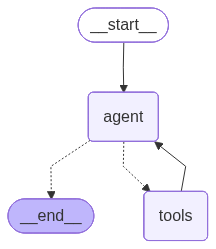

In [31]:
from IPython.display import display, Image

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# tools = [add, mul, search_tool, retriever_tool] + gmail_tools + arxiv_tools

In [36]:
from langchain_core.messages import HumanMessage

query = " 'Attention Is All You Need' 논문을 먼저 요약하고, 그 결과를 'limjangmook@gmail.com'으로 보내주세요"
responses = graph.stream({"messages": [HumanMessage(query)]}, stream_mode='values')
for response in responses:
    response["messages"][-1].pretty_print()

================================ Human Message =================================

 'Attention Is All You Need' 논문을 먼저 요약하고, 그 결과를 'limjangmook@gmail.com'으로 보내주세요
================================== Ai Message ==================================
Tool Calls:
  create_gmail_draft (73acb8a7-7d2e-4dcb-80ce-649545080ad9)
 Call ID: 73acb8a7-7d2e-4dcb-80ce-649545080ad9
  Args:
    message: Attention Is All You Need 논문 요약 내용을 첨부합니다.
    subject: [논문 요약] Attention Is All You Need
    to: ['limjangmook@gmail.com']
================================= Tool Message =================================
Name: create_gmail_draft

Draft created. Draft Id: r-3520693768407567463
================================== Ai Message ==================================

'Attention Is All You Need' 논문의 요약은 다음과 같습니다.

**Introduction**

Transformer 모델이 처음 제안된 때, Attention Mechanism은 순차적 인코더-디코더 구조를 갖는 모델이었지만, BERT, RoBERTa 및 GPT-2와 같은 transformer 기반의 언어 모델을 위해 재구성되었습니다. 이 논문에서는 Transformer 모델의 Attention Mechanism에 대한 새로운 접근 방

In [37]:
query = "3 곱하기 4 한 결과에 5를 곱하면?"
responses = graph.stream({"messages": [HumanMessage(query)]}, stream_mode='values')
for response in responses:
    response["messages"][-1].pretty_print()

================================ Human Message =================================

3 곱하기 4 한 결과에 5를 곱하면?
================================== Ai Message ==================================
Tool Calls:
  mul (30d9652d-1c8d-48eb-b9d4-26631c9c4bcc)
 Call ID: 30d9652d-1c8d-48eb-b9d4-26631c9c4bcc
  Args:
    a: 12
    b: 5
================================= Tool Message =================================
Name: mul

60
================================== Ai Message ==================================

3 곱하기 4 한 결과는 12입니다. 5를 곱한 결과는 60입니다.


In [38]:
query = "15억짜리 아파트 부동산 세금은 얼마야?"
responses = graph.stream({"messages": [HumanMessage(query)]}, stream_mode='values')
for response in responses:
    response["messages"][-1].pretty_print()

================================ Human Message =================================

15억짜리 아파트 부동산 세금은 얼마야?
================================== Ai Message ==================================
Tool Calls:
  real_estate_tax_retriever (f738a25d-f962-47e8-8d05-422f285bc0ea)
 Call ID: f738a25d-f962-47e8-8d05-422f285bc0ea
  Args:
    query: 안호골식 먹d일 번속사 짢햨
================================= Tool Message =================================
Name: real_estate_tax_retriever

제25조 삭제 <2007. 12. 31.>
  
부칙 <제20779호,2025. 3. 14.>
제1조(시행일) 이 법은 공포한 날부터 시행한다.
제2조(납부유예에 관한 적용례) 제20조의2의 개정규정은 이 법 시행 이후 납세의무가 성립하는 분부터 적용한다.

제25조 삭제 <2007. 12. 31.>
  
부칙 <제20779호,2025. 3. 14.>
제1조(시행일) 이 법은 공포한 날부터 시행한다.
제2조(납부유예에 관한 적용례) 제20조의2의 개정규정은 이 법 시행 이후 납세의무가 성립하는 분부터 적용한다.

출세액(공시가격합계액으로 안분하여 계산한 금액을 말한다)을 제외한 금액에 제6항의 표에 따른 연령별 공제율을
곱한 금액으로 한다.<개정 2022. 9. 15.>
1. 제8조제4항제1호에 해당하는 경우: 주택의 부속토지(주택의 건물과 부속토지의 소유자가 다른 경우의 그 부속토
지를 말한다)분에 해당하는 산출세액
2. 제8조제4항제2호에 해당하는 경우: 1주택을 양도하기 전 대체취득한 주택분에 해당하는 산출세액
3. 제8조제4항제3호에 해당하는 

In [39]:
query = "langgraph에서 사용할 무료 웹 검색 tool 추천해 줘"
responses = graph.stream({"messages": [HumanMessage(query)]}, stream_mode='values')
for response in responses:
    response["messages"][-1].pretty_print()

================================ Human Message =================================

langgraph에서 사용할 무료 웹 검색 tool 추천해 줘
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (4c770da1-43ac-4f8a-b1b2-01ff09594c25)
 Call ID: 4c770da1-43ac-4f8a-b1b2-01ff09594c25
  Args:
    query: free web search tools
================================= Tool Message =================================
Name: duckduckgo_search

Web Search tool scrapes Google results without API keys! Get structured search data with titles, URLs, & descriptions. Perfect for data collection & research.Enables free web searching using Google search results without requiring API keys. Search the web using Google search results. No API keys or authentication required. Returns structured results with titles, URLs, and descriptions. "The ' Search Tool ' extension makes searching simple. It lets you search selected words easily, pick how results show up, and group websites by cat